# <font color=red> ARX (AutoRegressive Neural Network). 
## <font color=red> Autoencoders LSTM for anomaly detection.

In the following website you can find the kaggle dataset https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k

**Load the necessary modules**

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('/content/iot_telemetry_data.csv')

* **ts:** timestamp of reading (seconds from 01-01-1970)
* **device:** unique device name
* **co:** carbon monoxide (ppm)
* **humidity:** humidity (%)
* **light:** light detection
* **lpg:** liquefied petroleum gas (ppm)
* **motion:** motion detected
* **smoke:** smoke (fine particles) (ppm)
* **temp:** temperature (F)

### **ts** : calculated with the unix timestamp (00:00 12-07-2020 = 1594512000 seconds). The unix timestamps starts from the 01-01-1970.


In the following chunk we create a new variable which we add to the dataframe, data. This variable is the same as ts, but each value is subtracted by 1594512000 because **our data starts from the twelfth of July 2020**. <br>
Eventually, we chose to work with minutes instead of seconds and so we created a time_m variable which represents the time in minutes.

In [ ]:
time_from_12_07_2020 = np.array(data.iloc[:, 0])-1594512000 
data['time'] = time_from_12_07_2020
data['time_m'] = (data['time']//60)+1

In the following chunks we:

1. Filter the dataset according to the first sensor (00:0f:00:70:91:0a) and assign the result in first_sensor. Then we do the same for the third sensor.
2. Group both of these datasets according to time_m because we have more observations with the same value of time_m and compute the mean of these values.
3. Do some plots.

In [ ]:
first_sensor = data.loc[data['device']=='00:0f:00:70:91:0a'].reset_index()
third_sensor = data.loc[data['device']=='1c:bf:ce:15:ec:4d'].reset_index()

In [ ]:
first_sensor_minute = first_sensor.groupby(['time_m']).mean().reset_index()
third_sensor_minute = third_sensor.groupby(['time_m']).mean().reset_index()

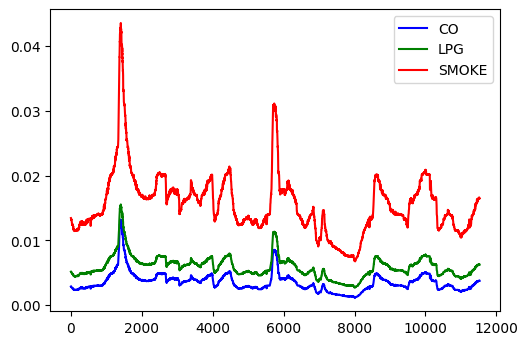

In [ ]:
plt.figure(figsize = (5.8, 4), dpi=100)
plt.plot(first_sensor_minute['time_m'], first_sensor_minute['co'], 'b-', label='CO')
plt.plot(first_sensor_minute['time_m'], first_sensor_minute['lpg'], 'g-', label='LPG')
plt.plot(first_sensor_minute['time_m'], first_sensor_minute['smoke'], 'r-', label='SMOKE')
plt.legend()
plt.show()

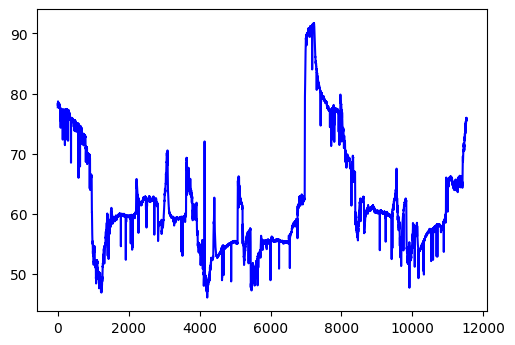

In [ ]:
plt.figure(figsize = (5.8, 4), dpi=100)
plt.plot(third_sensor_minute['time_m'], third_sensor_minute['humidity'], 'b-')
plt.show()

## <font color = red> Autoencoders (some theory)

Encoder and decoder are two neural networks.

**Encoder**: takes data with an high level of dimensionality (input) and **learns how to represent it in a much lower dimension**. It then pass the data to a **bottleneck (latent representation)** which is the separator of the encoder and the decoder.

**Decoder**: takes the data from the bottleneck and reconstructs the data and outputs the result in the same dimensionality of the input, hopefully losing as little information as possible and when it does this it **measures the reconstruction loss**. 

If the reconstrution loss (for a specific data point) is within the acceptable limits, then we can say that the data point is not anomaly.

**The autoencoders are used to remove the noise**

**The differences of the input values and the output (of the autoencoder) values generate a loss. The anomalies are the observations with the higher loss.**




**Contextual anomaly:**  if a data instance is anomalous in a specific context (but not otherwise). <br>
**Collective anomaly:** if a collection of related data instances is anomalous with respect to the entire data set.

A common example of collective anomalies are heartbeat abnormalities in electrocardiograms

## <font color=red> LSTM (some theory)

The gates used for ARX are "memory" gates. These gates can be **Long-Short Term Memory (LSTM)** or Gated Recurrent Unit (GRU). They are a special kind of **recurrent Neural Network (RNN)**, capable of learning long-term dependencies. LSTM gates are very used for this kind of application.

A **RNN** layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far. A problem which may arise is that, if we consider a big timestep (i.e. too many past information), then it's hard to make predictions because there are too many information to be processed.

The **LSTM** provides a solution to this long term dependency problem: adding a **state gate** to the RNN architecture. Such state contains all the output of the previous timesteps and consists of three parts:

* **Forget gate** says which information stored into the state can be forgotten (removed from the state). It can assumes values from 0 to 1.
* **Input gate** says what new information should be updated into the state. It can assumes values from 0 to 1.
* **Output gate** says, of all the information that are stored into the state, which one will be used for a specific instance. It can assume values from 0 to 1.

Tipical use cases for using LSTM: Machine translation, chat box (questions and answers).

## <font color=red> Dropout (some theory)

Dropout regularization is a technique to prevent neural networks from overfitting. Dropout works by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

You are removing different neurons on every pass through the network. Thus, you are actually training multiple networks with different compositions of neurons and averaging their results. In machine learning we could do this by combining more models (ensemble learning) which helps correcting mistakes produced by single models, but, in deep learning this approach would become prohibitively expensive. Dropout mitigates these problems. Since the model drops random neurons with every pass through the network, it essentially creates a new network on every pass. But weights are still shared between these networks contrary to ensemble methods, where each model needs to be trained from scratch.

The main benefit of dropout is **reducing the occurrence of coadaptations between neurons**. Coadaptations occur when neurons learn to fix the mistakes made by other neurons on the training data. The network thus becomes very good at fitting the training data. But it also becomes more volatile because the coadaptions are so attuned to the peculiarities of the training data that they won’t generalize to the test data. 

Dropout is only used during training to make the network more robust to fluctuations in the training data. At test time, however, you want to use the full network (you do not apply dropout).

When you have very large training data sets, the utility of regularization techniques, including dropout, declines because the network has more data available to learn to generalize better. When the number of training examples is very limited (<5000 according to the original dropout article linked above), other techniques are more effective. Dropout is especially popular in computer vision applications because vision systems almost never have enough training data.

**We use the dropout especially because to train our model we use all the data (with also the anomalies). The dropout avoids that the model overfits and learns how to reconstruct outliers.**

## <font color=red> Autoencoder with LSTM model.

The following function (ARX: autoregressive neural network) allows you to find anomalies of a time series (target parameter) of a data-set (data parameter) you load into the function. <br>
The used model is a LSTM both in encoder and decoder. <br>
You can choose (because are arguments of the function) the number of epochs, the batch size and the validation set ratio, but the dropout rate (0.2), the optimizer (adam), the loss function (mae) and other information like the early stopping are fixed and to change them you have to modify the function itself.<br>
Other info of how this function works are in the doc-string.

In [ ]:
def ARX(data, target, time_steps, time_variable, epochs, batch_size, validation_set_ratio):
  '''
  - This function takes as input a dataset, the target variable that you want to find the anomalies on, the string of the name of the time
    variable in your dataset, the number of epochs for your auto-encoder model, the batch size and the ratio of the validation set (notice
    that the validation set is the last part of the time-series (no shuffle)).

    It then trains the model and plots the training and the validation losses and the histogram of the recostruction loss. 
    Then it asks to the user a threshold to apply on the reconstruction loss (according to this threshold will be chosen the anomalies).
    Eventually, it plots the histogram of the reconstruction loss with the vertical line threshold and the plot of the anomalies.

  - It returns a dataframe of the anomalies.
  '''
  def create_sequences(df, target, time_steps) :
    '''
		- Assign X and y 
		- Create sequences according to a pre-defined time step
			(if time_steps=10, Xs will take the first 10 numbers and ys the 11th in the first iteration . . . 
			until the end when Xs won't take the last one, which is taken by ys)
		- Return Xs and ys
		'''
    X = df[[target]]
    y = df[target]
    
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
      
      Xs.append(X.iloc[i:(i+time_steps)].values) #X -> from i to i+time_steps
      ys.append(y.iloc[i+time_steps]) #y -> only i+time_steps
      
    return np.array(Xs), np.array(ys)

  def scale_data(data, target, time_variable): 
    '''
		- Create a df with our target feature
  	- Scale the df
  	- Add the feature 'Time' to the df
		- Return df
  	'''
    
    df = data.loc[:,target].to_frame()
    
    scaler = StandardScaler()
    df[target] = scaler.fit_transform(df[[target]])
    
    df["Time"] = data[time_variable]
    
    return df



  df = scale_data(data, target, time_variable) #scales the chosen sensor
  df_X, df_y = create_sequences(df, target, time_steps) # creates the sequences for it according to the time_step 

  
  # MODEL
  model = Sequential() #starts the model with a simple stack of layers
  model.add(LSTM(128, input_shape=(df_X.shape[1], df_X.shape[2]), return_sequences=False)) # adds neurons to the layers
  model.add(Dropout(rate=0.2)) # deactivates some neurons
  model.add(RepeatVector(df_X.shape[1])) # repeats the input n times
  model.add(LSTM(128, return_sequences=True)) 
  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(df_X.shape[2]))) # allows to apply a layer to each temporal slice of the input
  model.compile(optimizer='adam', loss='mae') # optimization functions and loss functions

  history = model.fit(df_X, df_y, epochs= epochs, batch_size=batch_size, validation_split=validation_set_ratio, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=50, mode='min')],
                                shuffle=False) 
  
  X_pred = model.predict(df_X, verbose=0) 
  mae_loss = np.mean(np.abs(X_pred - df_X), axis=1) 


  while True:
    plt.figure(figsize=(20,8), dpi=90)

    plt.subplot(121)
    train_loss, val_loss = history.history.values()
    x0 = np.arange(len(val_loss))
    plt.plot(x0, train_loss, 'b-', label = 'train_loss')
    plt.plot(x0, val_loss, 'y-', label = 'val_loss')
    plt.title('Training and validation loss', fontsize = 20)
    plt.legend(fontsize=15)

    plt.subplot(122)
    plt.hist(mae_loss, bins=30)
    plt.title('Reconstruction Loss', fontsize = 20)
    plt.show()

    time.sleep(2)

    threshold = float(input('Please enter a threshold: '))
    
    score_df = pd.DataFrame(df.iloc[time_steps:]) 
    score_df['loss'] = mae_loss
    score_df['threshold'] = threshold
    score_df['anomaly'] = score_df['loss'] > score_df['threshold']
    score_df[target] = df[target].iloc[time_steps:]

    anomalies = score_df.loc[score_df['anomaly'] == True]
    anomaly_times = anomalies['Time']

    anomalies_data = data.loc[data['time_m'].isin(anomaly_times)] 
    anomalies_data.shape # check how many anomalies there are

    plt.figure(figsize=(20,8), dpi=90)
    plt.subplot(121)
    plt.hist(mae_loss, bins=30)
    plt.axvline(threshold,color='red')
    plt.title('Reconstruction Loss with Threshold', fontsize = 20)
    
    plt.subplot(122)
    plt.plot(data['time_m'], data[target], 'b-', label=target)
    plt.plot(anomalies_data['time_m'], anomalies_data[target], 'r.', markersize = 15, label='Anomalies')
    plt.title('Anomaly plot', fontsize=20)
    plt.legend(fontsize=15) 

    plt.show()

    time.sleep(2)
    success_or_not = input('Would you like to change the threshold? (y/n)').lower()

    if success_or_not == 'n':
      break

  return anomalies_data

Epoch 1/500
288/288 [==============================] - 10s 9ms/step - loss: 0.1783 - val_loss: 0.1360
Epoch 2/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1428 - val_loss: 0.1446
Epoch 3/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1185 - val_loss: 0.1095
Epoch 4/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1104 - val_loss: 0.0855
Epoch 5/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1258 - val_loss: 0.1462
Epoch 6/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1761 - val_loss: 0.1246
Epoch 7/500
288/288 [==============================] - 2s 7ms/step - loss: 0.1661 - val_loss: 0.1907
Epoch 8/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1757 - val_loss: 0.1810
Epoch 9/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1657 - val_loss: 0.1684
Epoch 10/500
288/288 [==============================] - 2s 6ms/step - loss: 0.1542 - val_l

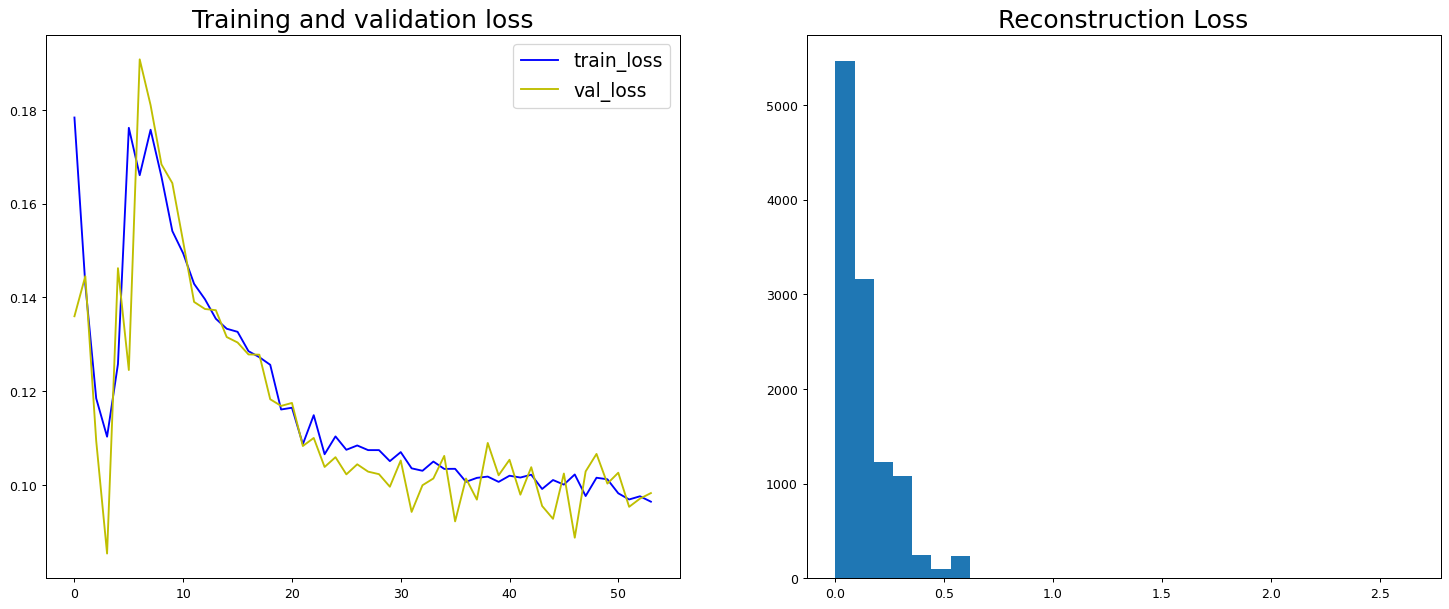

Please enter a threshold: 0.65


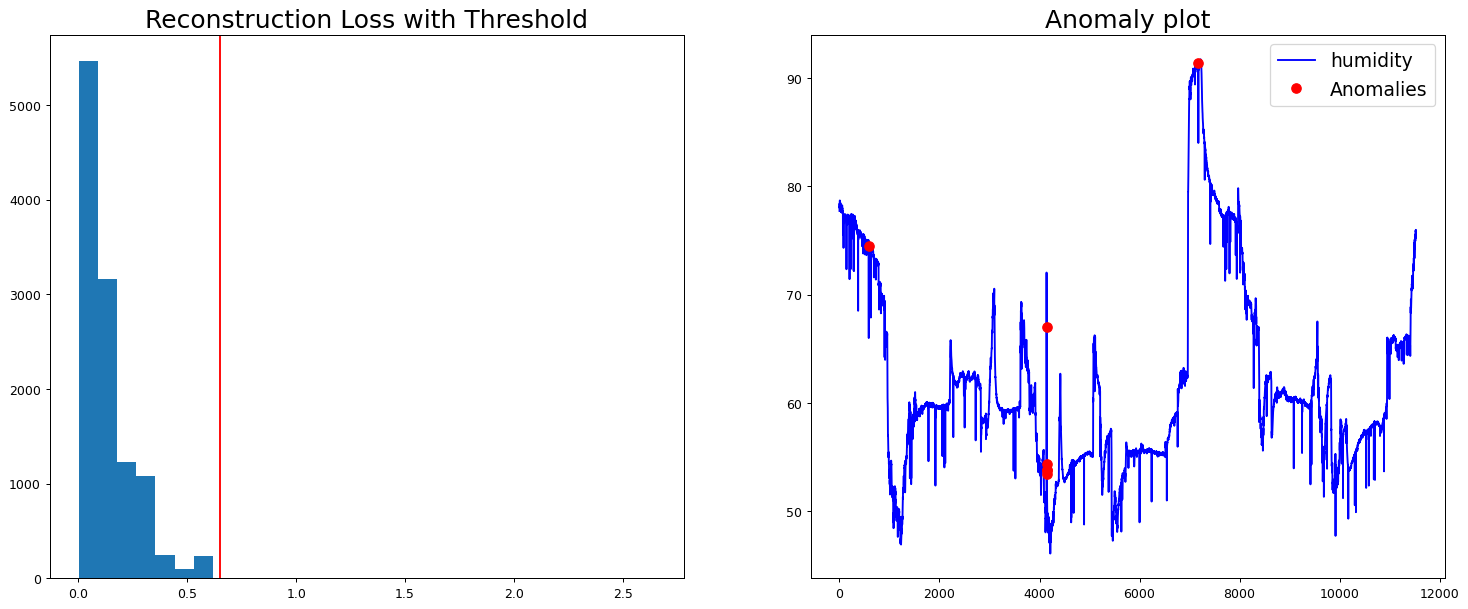

Would you like to change the threshold? (y/n)y


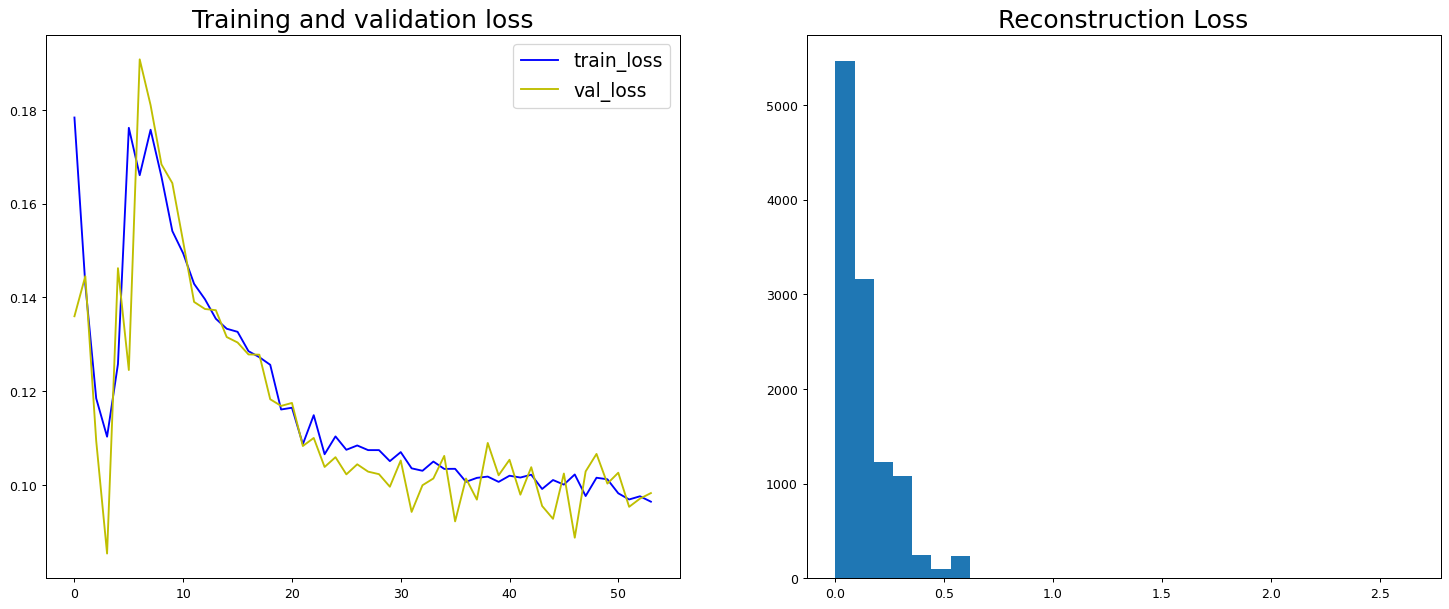

Please enter a threshold: 0.6


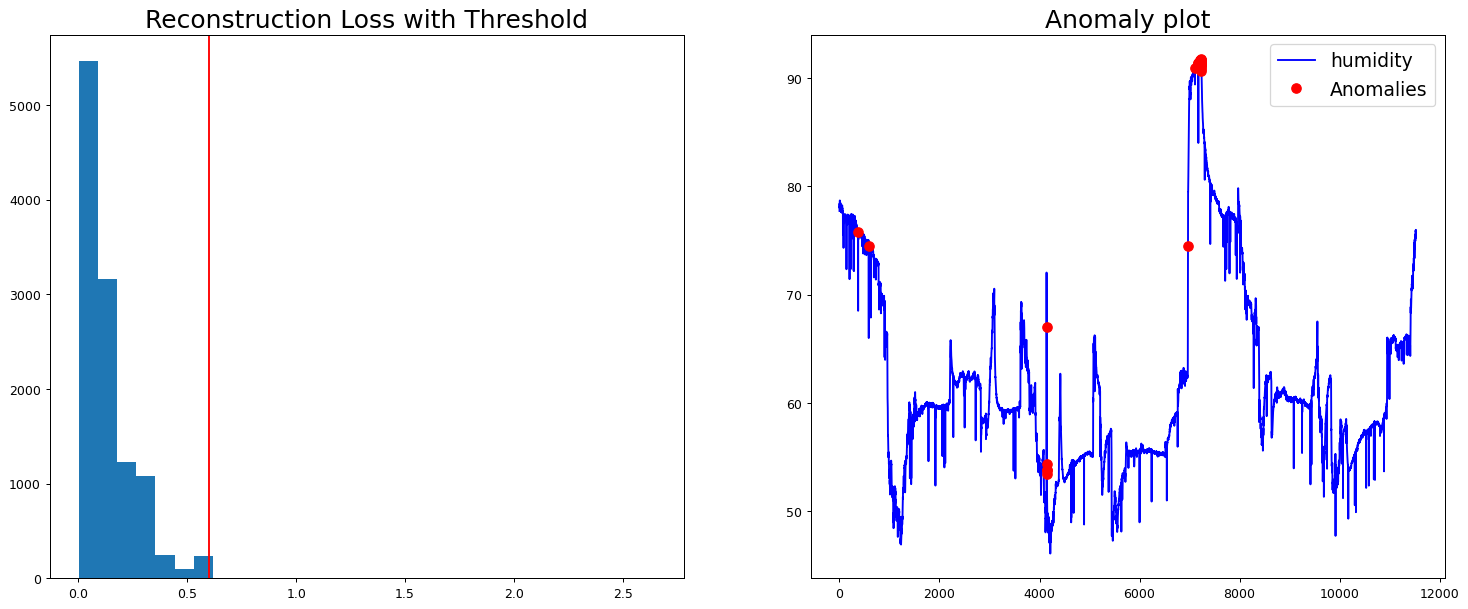

Would you like to change the threshold? (y/n)y


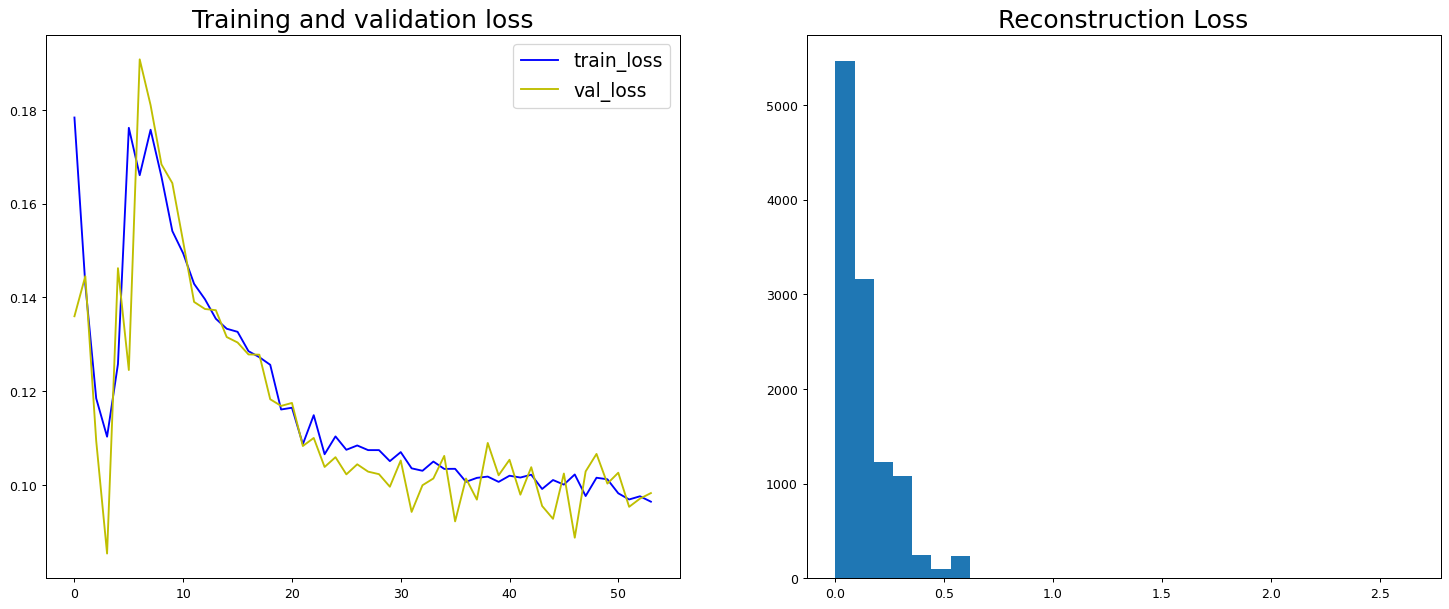

Please enter a threshold: 0.65


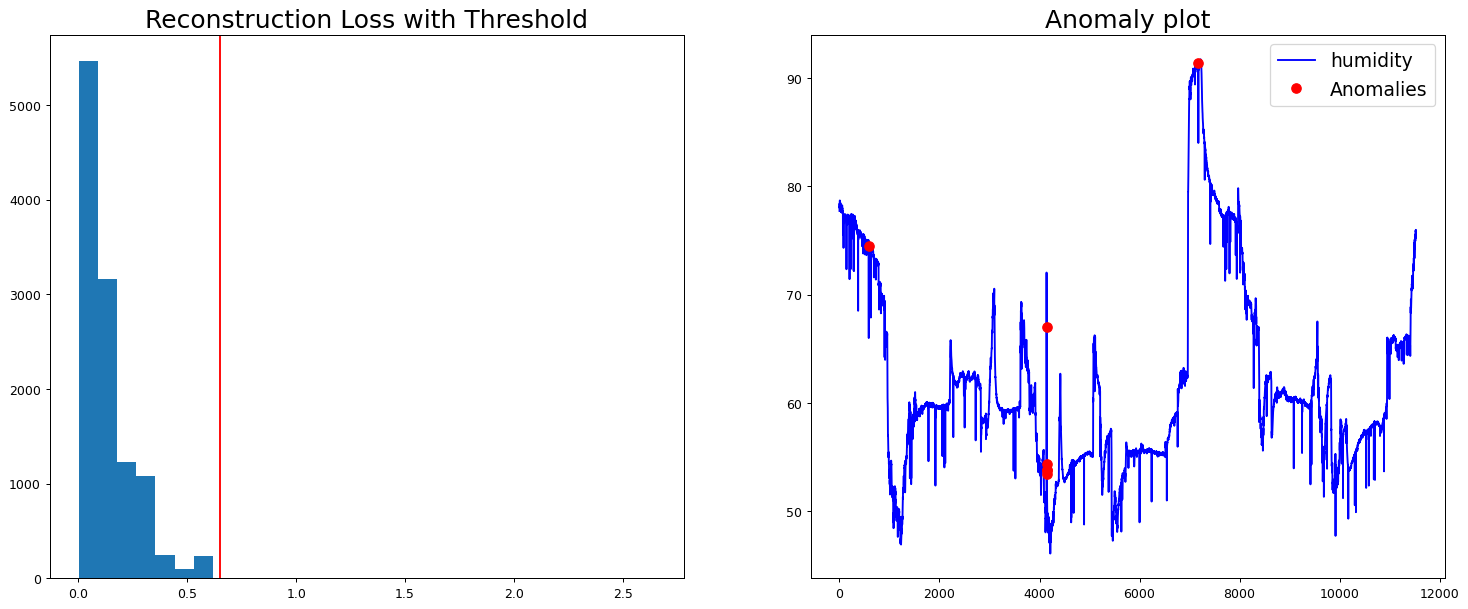

Would you like to change the threshold? (y/n)y


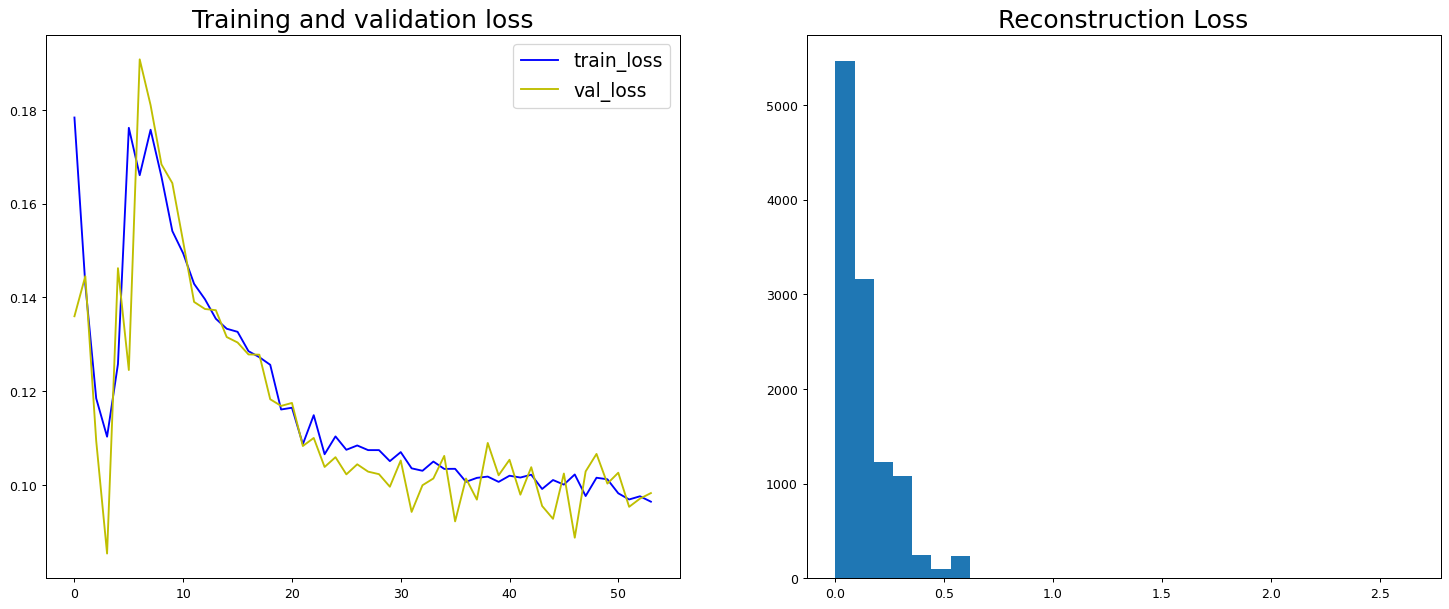

Please enter a threshold: 0.63


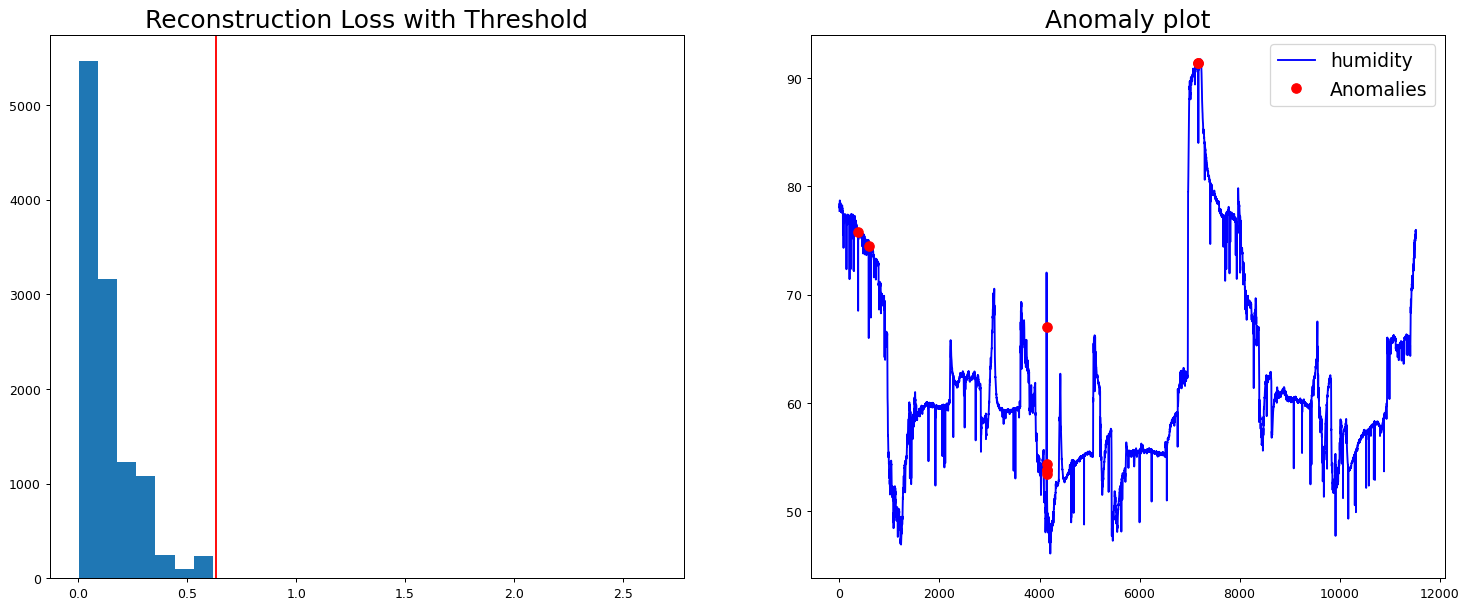

Would you like to change the threshold? (y/n)y


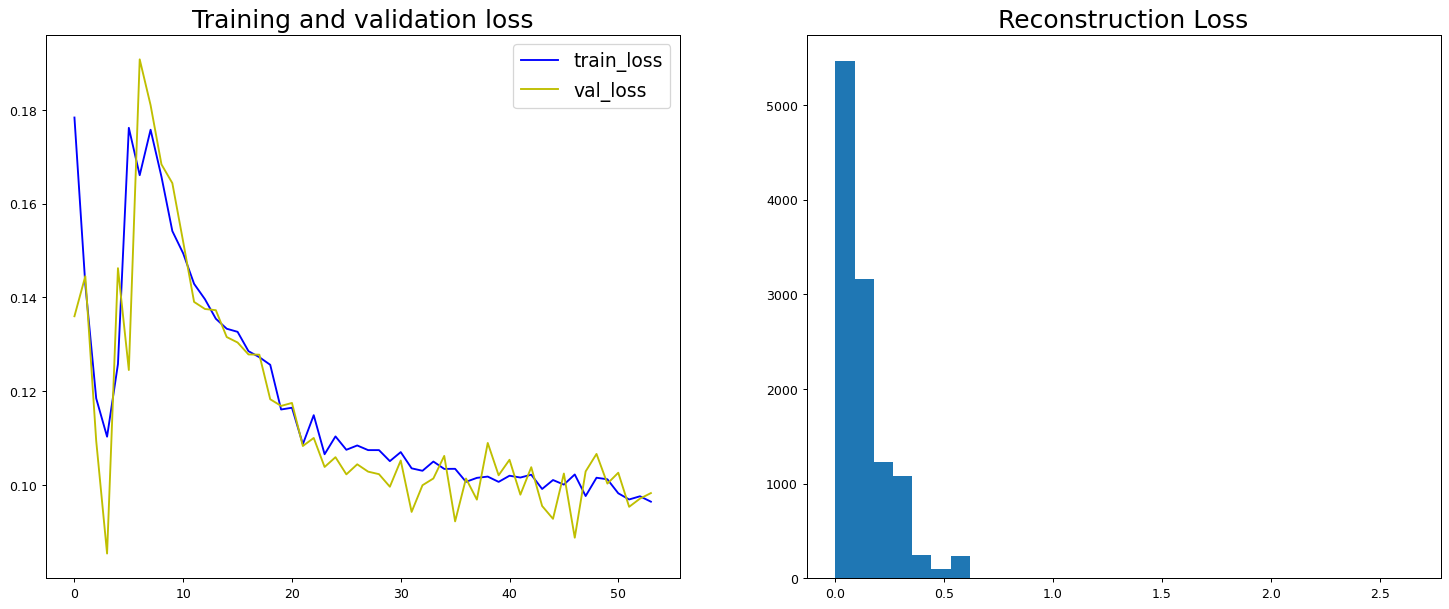

Please enter a threshold: 0.62


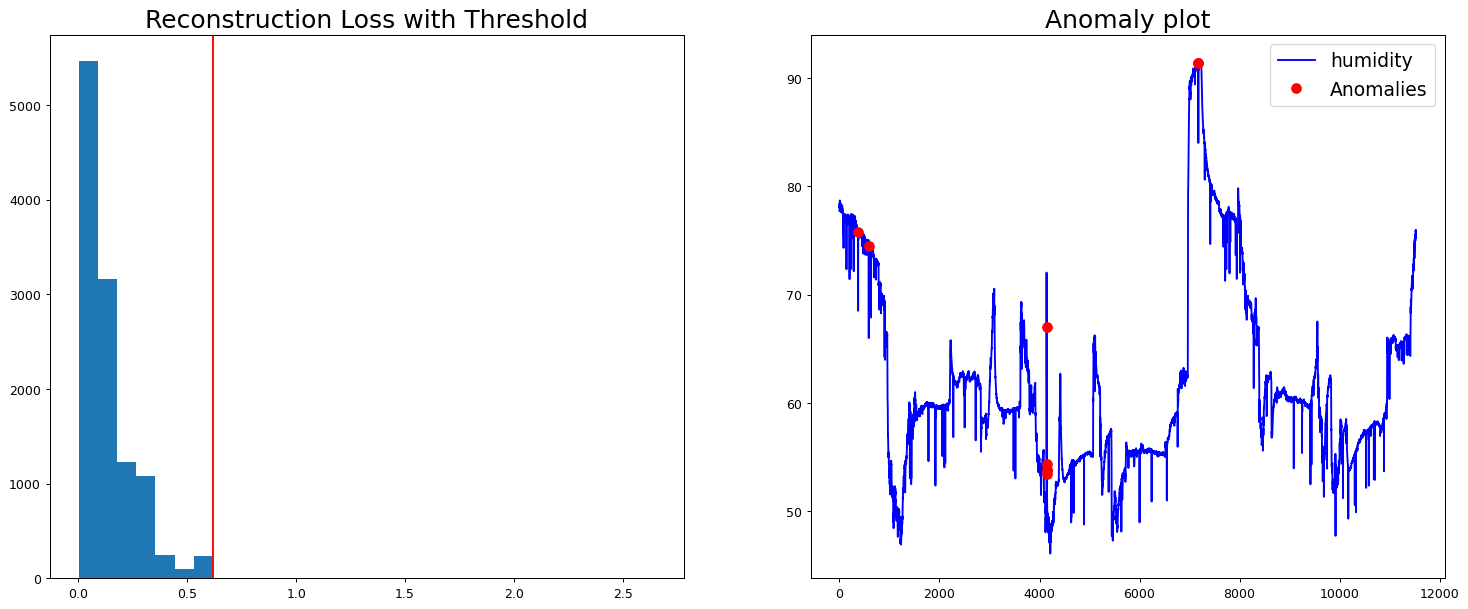

Would you like to change the threshold? (y/n)n


,time_m,index,ts,co,humidity,light,lpg,motion,smoke,temp,time
374,376.0,13344.000000,1.594535e+09,0.004089,75.742857,1.0,0.006657,0.000000,0.017593,25.400000,22531.214282
586,588.0,20591.100000,1.594547e+09,0.003889,74.460001,1.0,0.006420,0.000000,0.016924,24.319999,35248.554518
4140,4142.0,145041.909091,1.594760e+09,0.004728,67.045455,1.0,0.007395,0.181818,0.019684,26.745455,248489.303894
4141,4143.0,145078.727273,1.594761e+09,0.004728,54.336364,1.0,0.007394,0.000000,0.019681,26.600000,248551.441731
4142,4144.0,145116.000000,1.594761e+09,0.004729,53.840000,1.0,0.007396,0.000000,0.019685,26.600000,248613.037036
4143,4145.0,145148.300000,1.594761e+09,0.004718,53.810000,1.0,0.007383,0.000000,0.019650,26.620000,248669.360639
4144,4146.0,145185.666667,1.594761e+09,0.004714,53.400000,1.0,0.007378,0.000000,0.019636,26.722223,248734.339805
7174,7176.0,252571.888889,1.594943e+09,0.004268,91.355557,1.0,0.006867,0.000000,0.018186,23.533333,430529.180605
7176,7178.0,252641.600000,1.594943e+09,0.004311,91.350002,1.0,0.006917,0.000000,0.018328,23.480000,430653.396200


In [ ]:
ARX(data=third_sensor_minute, target='humidity', time_steps=5, time_variable='time_m', epochs=500, batch_size=32,validation_set_ratio=0.2)

# <font color =red> **Humidity analysis third sensor** 

In [ ]:
def create_sequences(df, target, time_steps) :
		'''
		- Assign X and y 
		- Create sequences according to a pre-defined time step
			(if time_steps=10, Xs will take the first 10 numbers and ys the 11th in the first iteration . . . 
			until the end when Xs won't take the last one, which is taken by ys)
		- Return Xs and ys
		'''

		X = df[[target]]
		y = df[target]

		Xs, ys = [], []
	
		for i in range(len(X)-time_steps):

			Xs.append(X.iloc[i:(i+time_steps)].values) #X -> from i to i+time_steps
			ys.append(y.iloc[i+time_steps]) #y -> only i+time_steps
	
		return np.array(Xs), np.array(ys)


In [ ]:
def scale_data(data, target, time): 
		'''
		- Create a df with our target feature
  	- Scale the df
  	- Add the feature 'Time' to the df
		- Return df
  	'''
		df = data.loc[:,target].to_frame()
	
		scaler = StandardScaler()
		df[target] = scaler.fit_transform(df[[target]])
		
		df["Time"] = data[time]
		
		return df

In [ ]:
Time_step=5 #sets the time_step

df = scale_data(third_sensor_minute, 'humidity', 'time_m') #scales the chosen sensor
df_X, df_y = create_sequences(df, 'humidity', Time_step) #creates the sequences for it according to the time_step 

In [ ]:
# MODEL
model = Sequential() #starts the model with a simple stack of layers
model.add(LSTM(128, input_shape=(df_X.shape[1], df_X.shape[2]), return_sequences=False)) #adds neurons to the layers
model.add(Dropout(rate=0.2)) #deactivates some neurons
model.add(RepeatVector(df_X.shape[1])) #repeats the input n times
model.add(LSTM(128, return_sequences=True)) 
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(df_X.shape[2]))) #allows to apply a layer to each temporal slice of the input
model.compile(optimizer='adam', loss='mae') #adds the chosen opt and loss functions

history = model.fit(df_X, df_y, epochs=100, batch_size=64, validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
										          shuffle=False) 

Epoch 1/100
144/144 [==============================] - 9s 11ms/step - loss: 0.2985 - val_loss: 0.1092
Epoch 2/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1703 - val_loss: 0.1066
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1621 - val_loss: 0.1270
Epoch 4/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1498 - val_loss: 0.1160
Epoch 5/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1420 - val_loss: 0.0971
Epoch 6/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1410 - val_loss: 0.0984
Epoch 7/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1372 - val_loss: 0.1021
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1347 - val_loss: 0.1051
Epoch 9/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1350 - val_loss: 0.1091
Epoch 10/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1323 - val_l

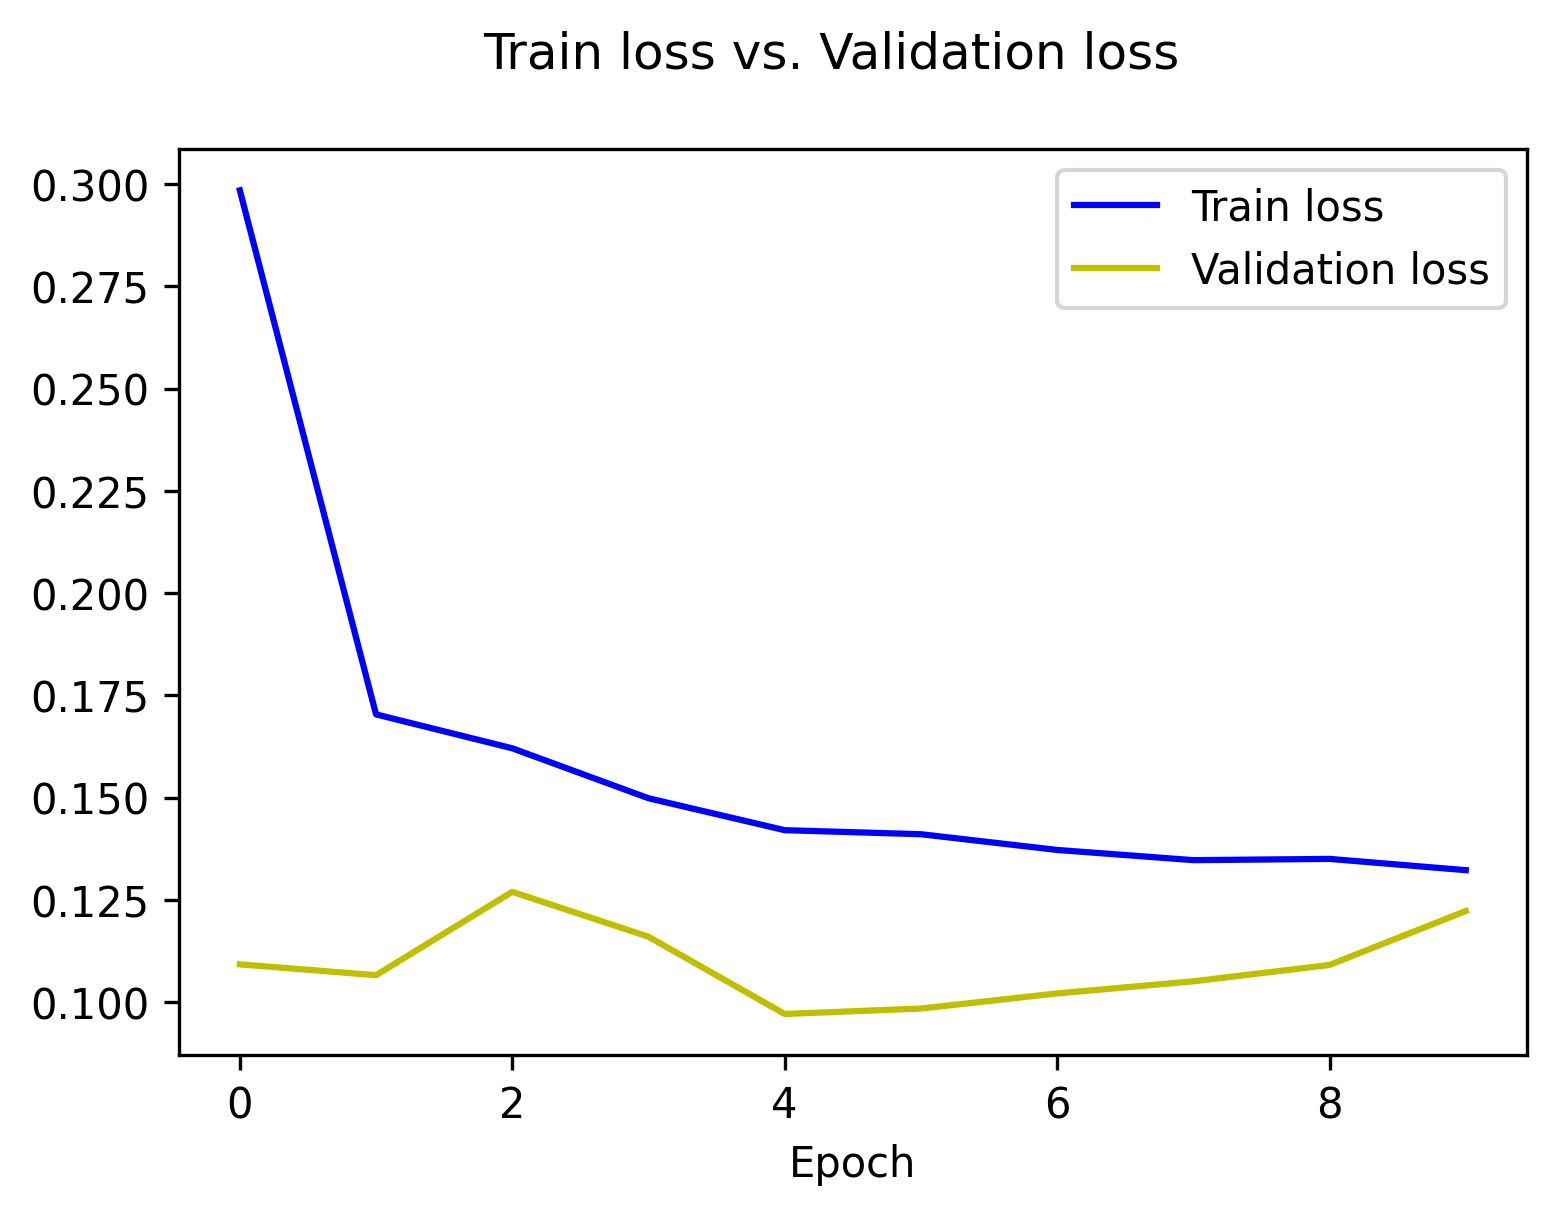

In [ ]:
train_loss, val_loss = history.history.values()

x0 = np.arange(len(val_loss))

plt.figure(figsize = (5.8, 4), dpi=300)
plt.plot(x0, train_loss, 'b-', label = 'Train loss')
plt.plot(x0, val_loss, 'y-', label = 'Validation loss')
plt.suptitle("Train loss vs. Validation loss")
plt.xlabel("Epoch")
plt.savefig("Train_vs_valid.png")
plt.legend()

In [ ]:
# Plot the histogram of the predictions and the loss function to chose the proper treshold
X_pred = model.predict(df_X, verbose=0) #y axis
mae_loss = np.mean(np.abs(X_pred - df_X), axis=1) #x axis

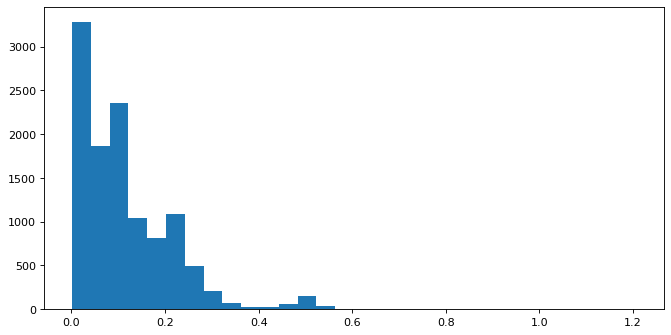

In [ ]:
plt.figure(figsize=(10,5), dpi = 80)
plt.hist(mae_loss, bins=30)
plt.show()

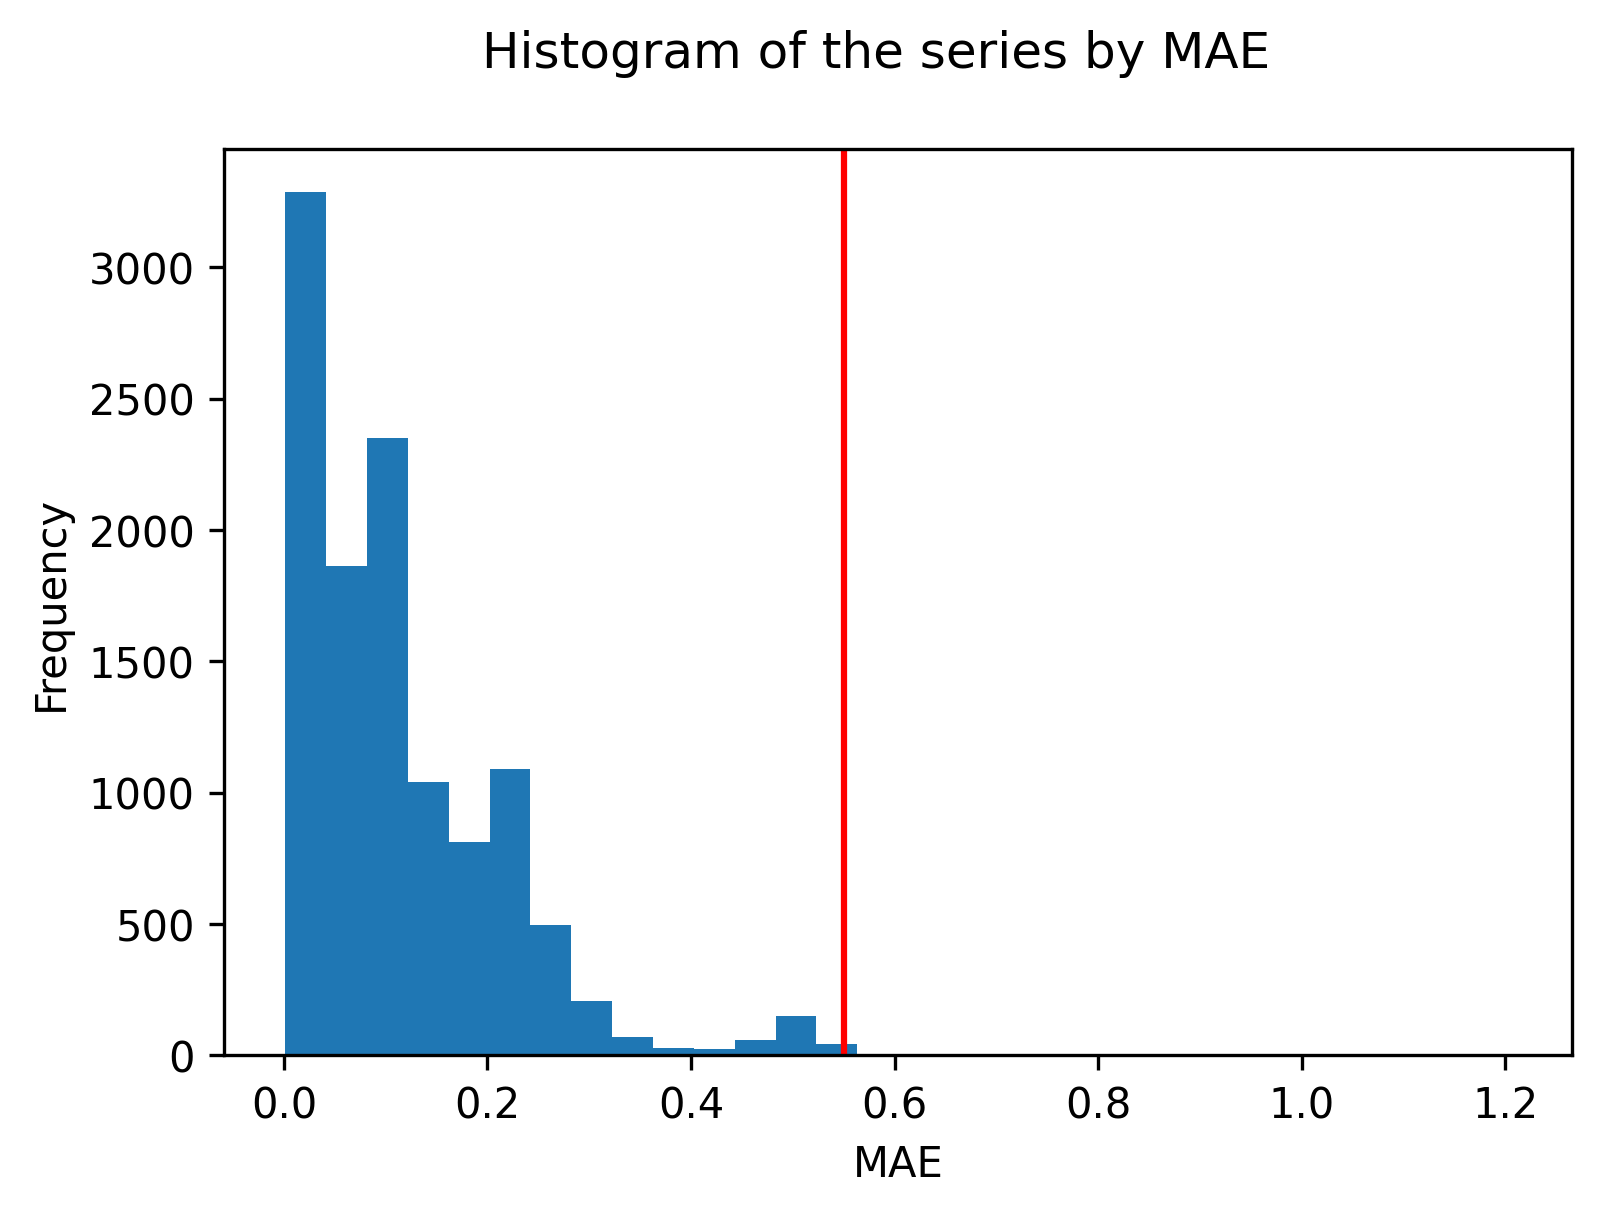

In [ ]:
# Set and plot the threshold
plt.figure(figsize = (5.8, 4), dpi=300)
plt.hist(mae_loss, bins=30)

threshold = 0.58 #chosen by the user
plt.axvline(threshold,color='red')
plt.suptitle("Histogram of the series by MAE")
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.savefig("MAE_hist.png")
plt.show()

In [ ]:
# Assign the scores to set up the model
# Assign the 'time' feature
score_df = pd.DataFrame(df.iloc[Time_step:]) 
score_df['loss'] = mae_loss
score_df['threshold'] = threshold
score_df['anomaly'] = score_df['loss'] > score_df['threshold']
score_df['humidity'] = df['humidity'].iloc[Time_step:]

anomalies_humidity = score_df.loc[score_df['anomaly'] == True]
anomaly_times_humidity = anomalies_humidity['Time']

In [ ]:
anomalies_third_sensor_humidity = third_sensor_minute.loc[third_sensor_minute['time_m'].isin(anomaly_times_humidity)] 
anomalies_third_sensor_humidity.shape #check how many anomalies there are

(6, 11)

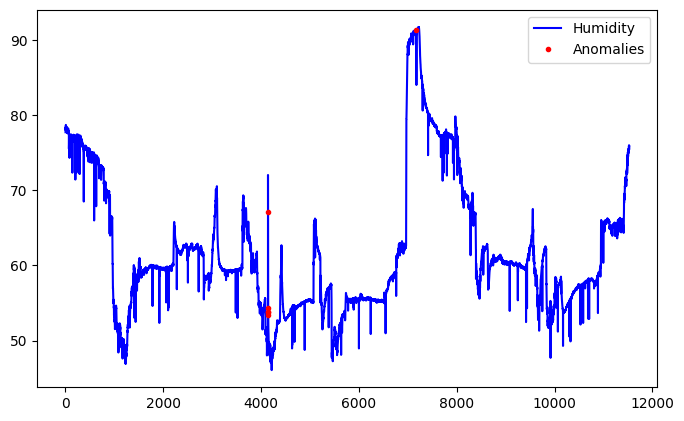

In [ ]:
# Plot the results
plt.figure(figsize=(8,5), dpi=100)
plt.plot(third_sensor_minute['time_m'], third_sensor_minute['humidity'], 'b-', label='Humidity')
plt.plot(anomalies_third_sensor_humidity['time_m'], anomalies_third_sensor_humidity['humidity'], 'r.', label='Anomalies')

plt.legend()
plt.show()